# (핸즈온 7장) – 앙상블 학습과 랜덤 포레스트
- 배깅, 부스팅, 스태킹 소개
- 직접 투표 (다수결 투표): 개별 모델의 성능보다 높을 때가 많다 (babe)
- 앙상블 모델은 각 모델이 서로 독립적일 때 가장 성능이 좋다 (다른 모델을 쓰면 좋다)


# 설정

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
# PROJECT_ROOT_DIR = "."
# CHAPTER_ID = "ensembles"
# IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
# os.makedirs(IMAGES_PATH, exist_ok=True)

# def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
#     path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
#     print("그림 저장:", fig_id)
#     if tight_layout:
#         plt.tight_layout()
#     plt.savefig(path, format=fig_extension, dpi=resolution)

%config InlineBackend.figure_format = 'retina'

# 투표기반 분류기
- 다른 모델을 사용하고 직접 투표 또는 간접투표를 한다


## Two Moon Data

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

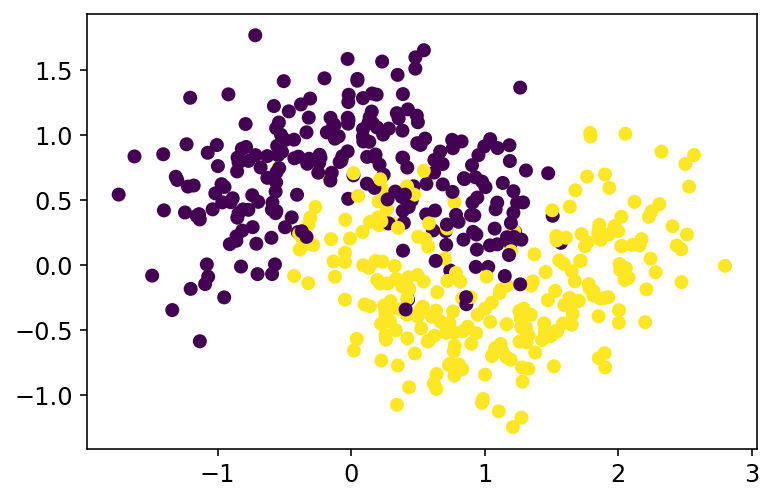

In [3]:
plt.scatter(X[:,0], X[:,1], c=y)

**노트**: 향후 버전을 위해 사이킷런에서 기본 값이 될 `solver="lbfgs"`, `n_estimators=100`, `gamma="scale"`로 지정합니다.

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [5]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

In [6]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


## 간접 투표
- SVC는 클래스 확률을 제공하지 않으므로 이를 얻으려면 명시적으로 probabbility=True를 지정해야 한다 (단, 클래스 확률을 구하기 위해서 교차검증을 해야 하고 속도는 느려진다)


In [7]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

In [8]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# 배깅 앙상블
- "같은" 모델을 사용하고 데이터를 무작위로 달리 사용한다
- 배깅: 중복허용 (bootstrap aggregation)
- 페이스팅: 중복 불 허용
- 배깅이 페이스팅보다 편향이 조금 높다. 다양성이 증가하여 분산은 감소한다 (일반적으로 배깅을 선호한다)
- 분류는 최빈값을, 회귀는 평균값을 사용
- 앙상블로 분산을 줄지만 편향은 비슷하다
- 병렬로 처리할 수 있다

- 무작위로 100개의 샘플만 사용하며, 500개의 모델을 만든다 (훈련 데이터는 375개임)


In [9]:
X_train.shape

(375, 2)

In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [11]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


## 결정트리와 비교

In [12]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


## (참고) 결정 경계 비교
- 배깅을 사용한 경우의 결정경계가 더 일반적이다

In [50]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]  # (10000,2)
    y_pred = clf.predict(X_new).reshape(x1.shape) # (100,100)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.7)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

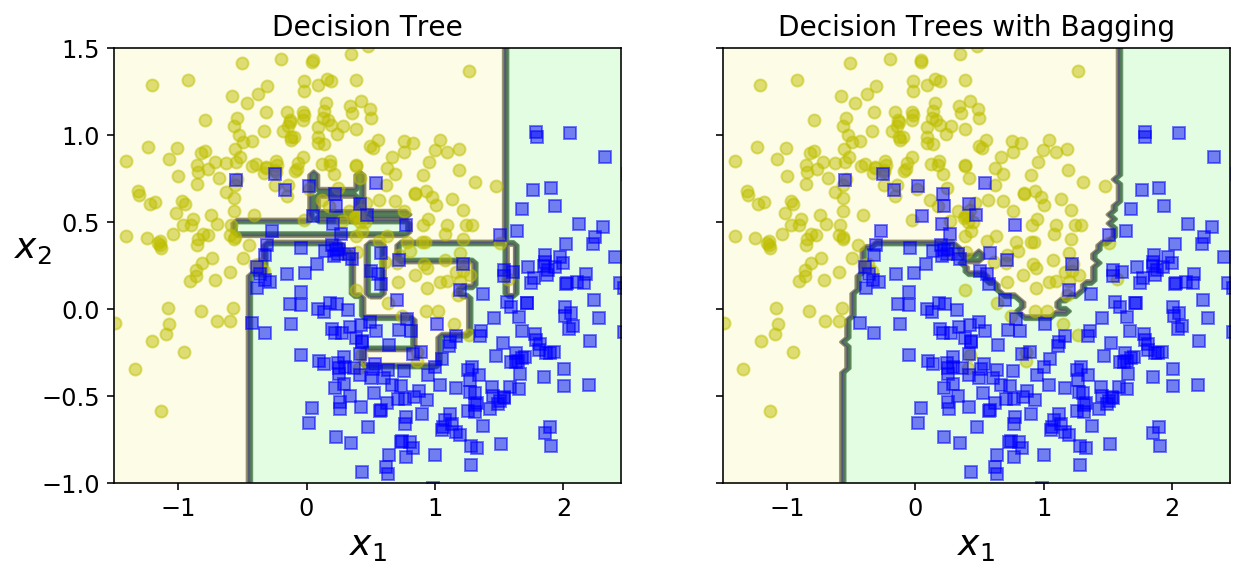

In [51]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
# save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

## OOB 평가
- 훈련에 사용되지 않는 37%의 데이터를 검증에 사용
- 선택되지 않을 확률: e**(-1)
- 선택될 확률: (1 - e**(-1))
- oob_score=True로 하면 자동으로 평가를 해준다 (검증 데이터를 따로 사용하지 않는다)

In [52]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

In [53]:
bag_clf.oob_decision_function_[:10]

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.08379888, 0.91620112],
       [0.31693989, 0.68306011],
       [0.02923977, 0.97076023],
       [0.97687861, 0.02312139],
       [0.97765363, 0.02234637]])

- 별도의 검증 데이터에 대한 성능으로 확인 

In [54]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

## 특성 샘플링
- BaggingClassifier는 특성 샘플링도 지원한다
- 이는 특히 고차원의 데이터셋에서 유용하다
- 특성과 샘플을 모두 샘플링하는 것을 랜덤 패치방식이라고 한다
- 한편, 특성만 샘플링하는 것은 랜덤 서브스페이스 방식이라고 한다

# 랜덤 포레스트
-  배깅을 적용한 결정트리 앙상블 기법
- 아래와 같이 결정트리를 명시하는 방법도 있고, 특화된 랜덤 포레스트를 직접 사용하는 방법도 있다
- 위 두방식은 거의 비슷하게 동작한다

In [0]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, random_state=42)

In [0]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [0]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [21]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # almost identical predictions

0.976

## 특성 중요도
- 평균적으로 불순도를 감소시키는데 기여한 정도로 계산한다
- 연관된 훈련 샘플수를 가중치에 반영한다

In [22]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [23]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

## MNIST에서 특성 중요도

In [0]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [25]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

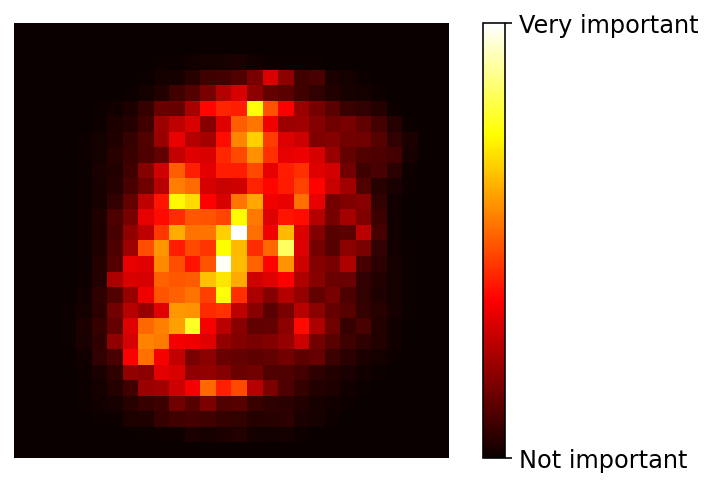

In [27]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

# save_fig("mnist_feature_importance_plot")
plt.show()

# 부스팅
- hypothesis boosting
- 앞의 약한 모델을 보완해 나가는 앙상블 모델

# 에이다부스트
- adaptive boosting
- 이전 모델에서 과소적합했던 훈련 샘플의 가중치를 더 높여주는 것 (학습하기 어려운 샘플에 점점 더 맞춰진다)
- 잘 못 분류된 훈련 샘플의 가중치를 높인다, 두번째 분류기는 업데이트된 가중치를 사용하여 "예측기"를 만들어본다 (단계별로 채점을 해보는 것임)
- 경사하강법이 "손실함수"를 점차 줄이듯이, 에이다 부스트는 예측기를 만들어 "성능"이 좋아지도록 학습한다.
- 모든 예측기를 만든 이후에 배깅이나 페이스팅을 적용한다. 단 가중치가 적용된 정확도에 따라 예측기마다 다른 가중치를 적용한다
- 병렬처리는 안된다
## 예
- SAMME : Stagewise Additive Modeling
using a Multi-class Exponential loss function (R: Real, 클래스 확률 계산)
- 일정수의 예측기를 정하거나 완벽한 분류를 하면 종료한다
- 과대적합이 되면 추정기의 수를 줄이거나 규제화를 한다

<img src= "https://bit.ly/2zjphkA" width="500">

In [28]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

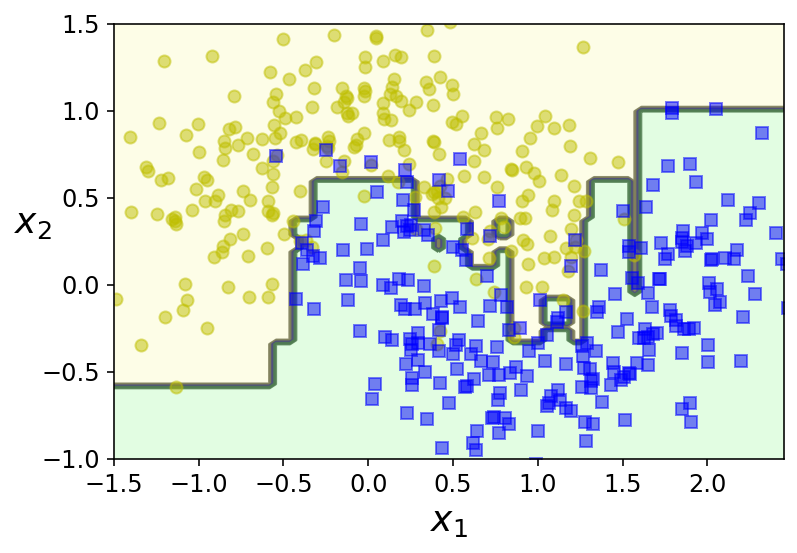

In [29]:
plot_decision_boundary(ada_clf, X, y)

## 결정 경계의 변화
- SVM을 사용한 예 (잘 사용하지는 않는다)

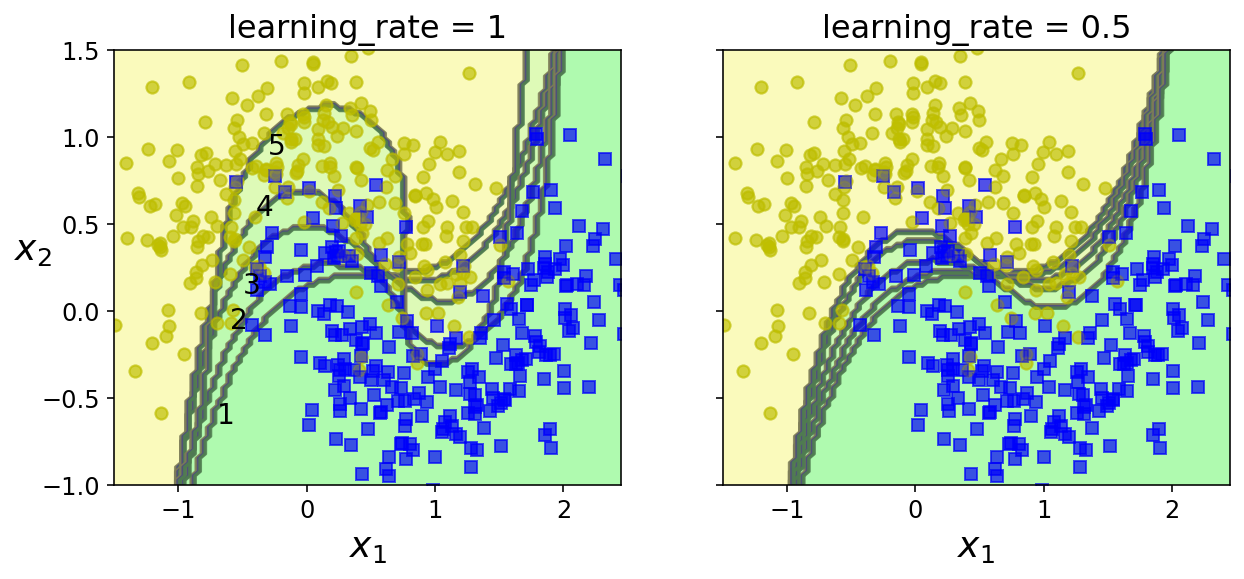

In [30]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m)
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

# save_fig("boosting_plot")
plt.show()

In [0]:
### list(m for m in dir(ada_clf) if not m.startswith("_") and m.endswith("_"))

# 그레이디언트 부스팅
- 에이다 부스트에서는 가중치를 수정하였지만, 이전 예측기가 만든 잔여 오차에 새로운 예측기를 학습시킨다

In [0]:
# 2차원으로 X를 생성
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [33]:
#  X -> y 예측기
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [34]:
# X -> y2 예측기 (y2는 잔여 오차)
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [35]:
# X -> y3 예측기 (y3는 두번째 잔여 오차)

y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [0]:
X_new = np.array([[0.8]])

In [0]:
# 3개의 모델의 합을 구한다
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [38]:
y_pred

array([0.75026781])

In [0]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

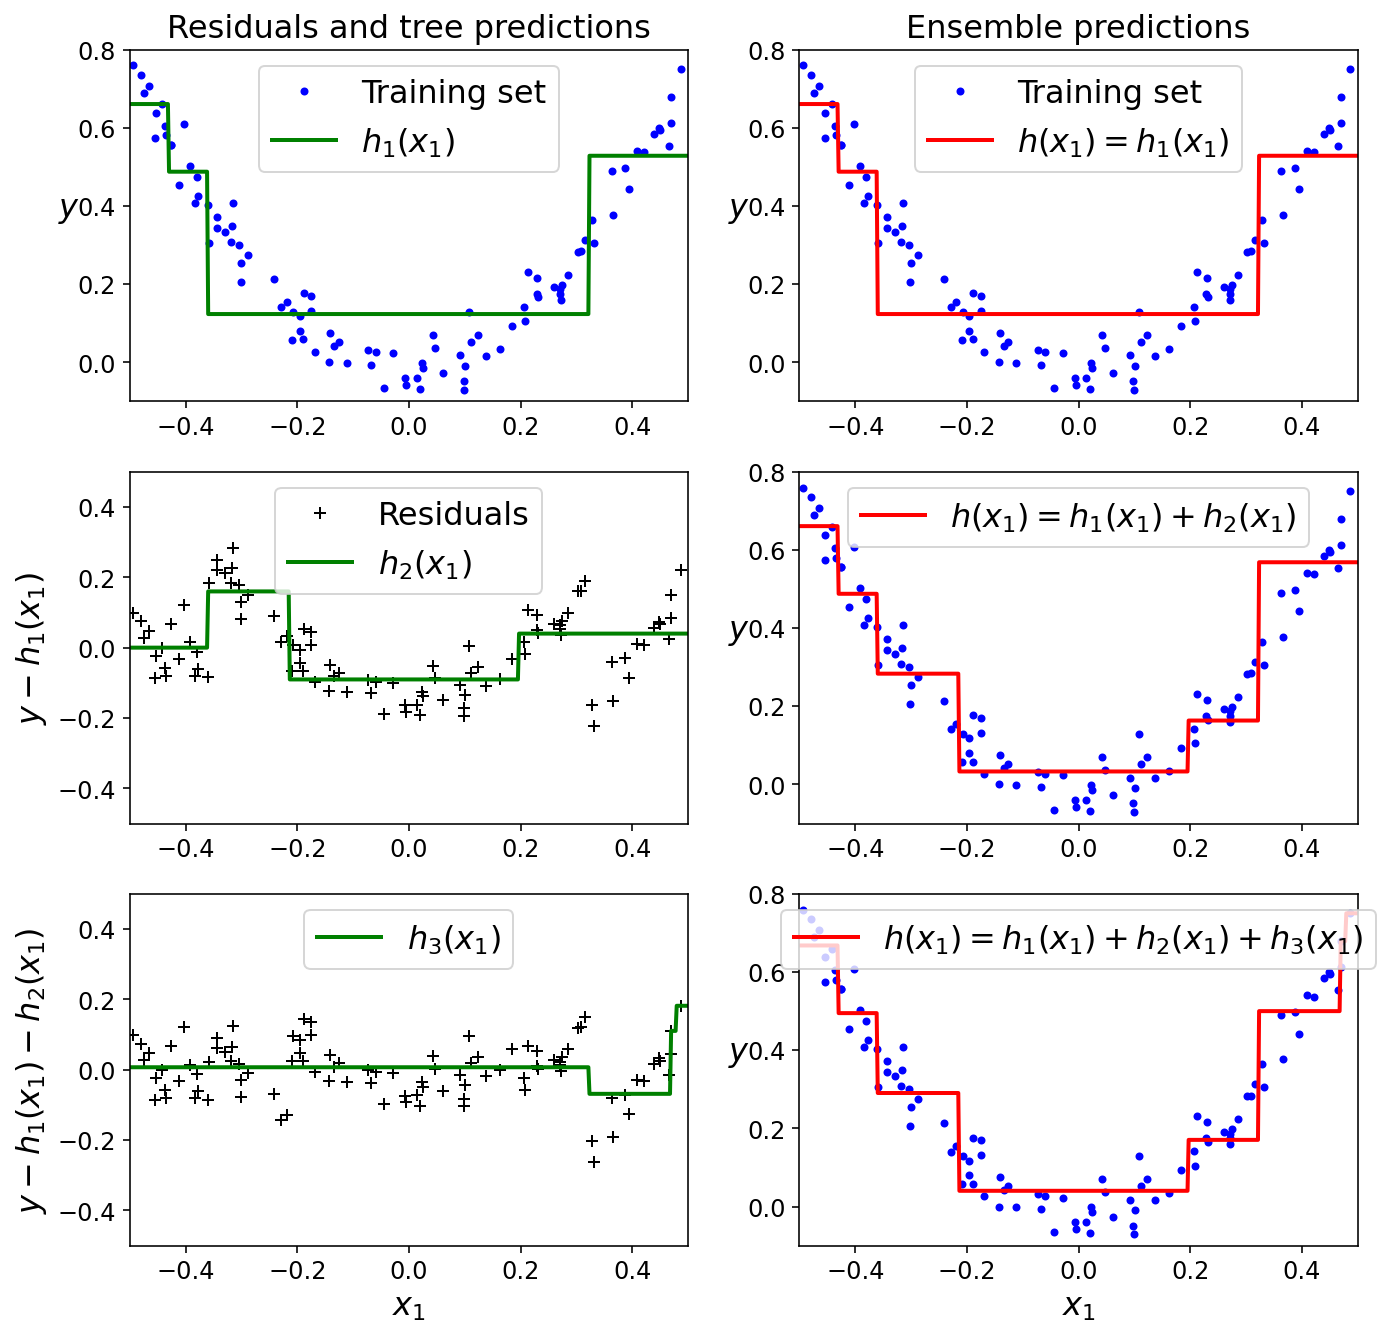

In [40]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

# save_fig("gradient_boosting_plot")
plt.show()

- 좌측은 예측기의 순차적인 동작을 설명
- 우측은 앙상블의 예측 (합)을 보여준다
- 학습률을 작게 잡으면 학습을 오래하지만 (많은 트리를 필요) 성능은 좋아진다 (shrinkage 규제)

In [41]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [42]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

- 과소적합(적은 수의 트리 사용)과 과대적합과 (너무 많은 트리 사용)
- subsample 로 샘플을 취할 비율을 조정할 수 있다. 훈련 속도가 빨라진다 (확률적 그라디언트 부스팅)

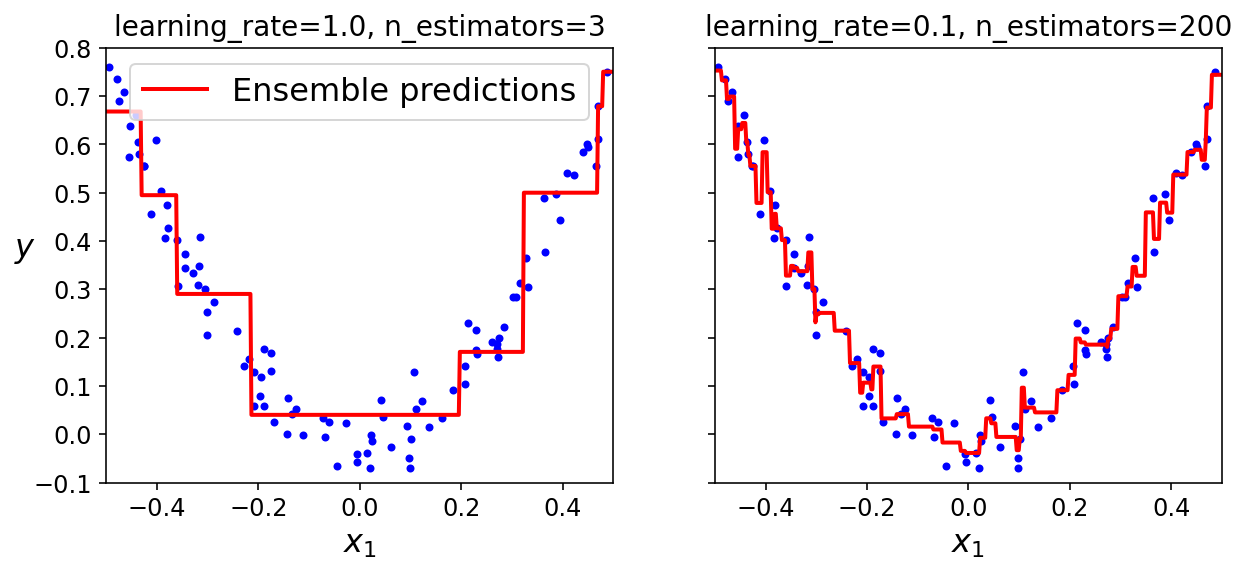

In [43]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

# save_fig("gbrt_learning_rate_plot")
plt.show()

## 조기 종료를 사용한 그래디언트 부스팅
- staged_predict() 사용

In [44]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=56,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
min_error = np.min(errors)

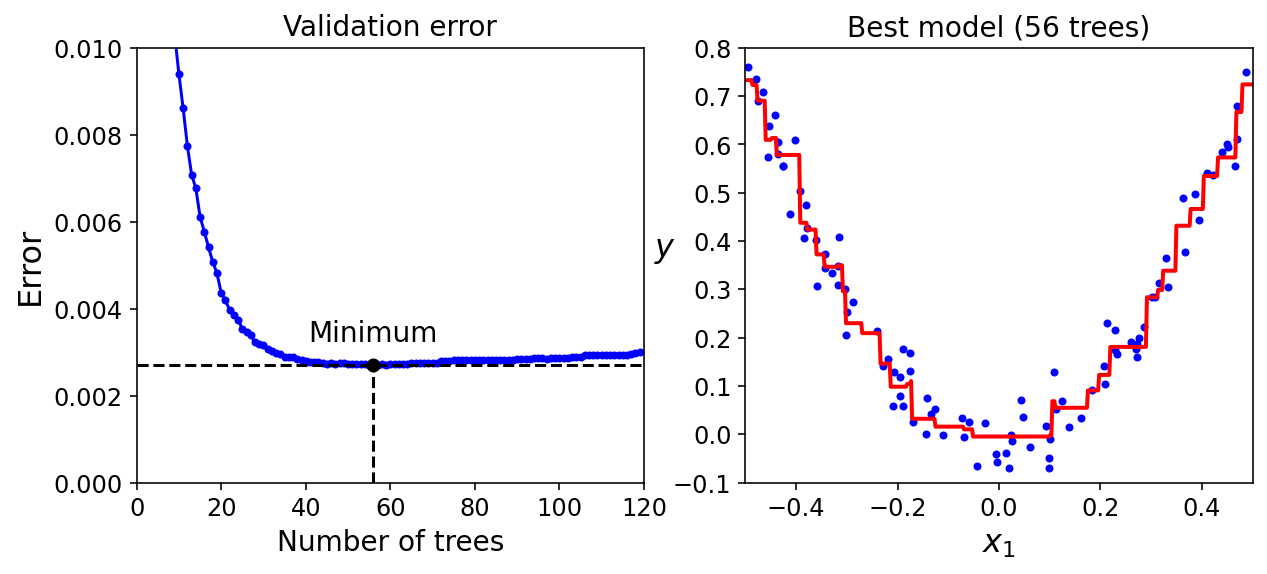

In [46]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

# save_fig("early_stopping_gbrt_plot")
plt.show()

-  warm_start=True : 기존 트리를 유지하며 훈련을 추가할 수 있도록 한다
- 검증 오차 향상을 5회 기다린다 (종료전에)

In [0]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [48]:
print(gbrt.n_estimators)

61


In [49]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


## XGBoost 사용하기
- extreme gb

In [0]:
try:
    import xgboost
except ImportError as ex:
    print("에러: xgboost 라이브러리 설치되지 않았습니다.")
    xgboost = None

In [51]:
if xgboost is not None:
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) 
    print("Validation MSE:", val_error)          

[13:40:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation MSE: 0.0028512559726563943


- 조기 종료 설정

In [52]:
if xgboost is not None: 
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    print("Validation MSE:", val_error)           

[13:40:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.286719
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.258221
[2]	validation_0-rmse:0.232634
[3]	validation_0-rmse:0.210526
[4]	validation_0-rmse:0.190232
[5]	validation_0-rmse:0.172196
[6]	validation_0-rmse:0.156394
[7]	validation_0-rmse:0.142241
[8]	validation_0-rmse:0.129789
[9]	validation_0-rmse:0.118752
[10]	validation_0-rmse:0.108388
[11]	validation_0-rmse:0.100155
[12]	validation_0-rmse:0.09208
[13]	validation_0-rmse:0.084791
[14]	validation_0-rmse:0.078699
[15]	validation_0-rmse:0.073248
[16]	validation_0-rmse:0.069391
[17]	validation_0-rmse:0.066277
[18]	validation_0-rmse:0.063458
[19]	validation_0-rmse:0.060326
[20]	validation_0-rmse:0.0578
[21]	validation_0-rmse:0.055643
[22]	validation_0-rmse:0.053943
[23]	validation_0-rmse:0.053138
[24]	validation_0-rmse:0.052415
[25]	validation_0-rmse